# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Подберите еще одну задачу, которая уже решена (если не NST)
* Повторите решение, которое уже есть$^2$ (если не NST)
* Решите свою задачу

---------------------------------------
1. Расположены в порядке возрастания сложности и крутизны
2. Поверьте если вы сделаете этот пункт следующий будет в *разы* легче

## Если вы выбрали CycleGAN
--------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для CycleGAN модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. CycleGAN в этом смысле хуже, чем pix2pix, он ест больше памяти. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все беcплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Remarks:
-----------------------------------------

* Это задание нужно для того, чтобы вы наступили на все грабли, что есть. Узнали об их существовании и научились обходить. Посмотрели на неработающие модели и поняли, что все тлен. Изгуглили весь интернет и в конце заставили это все работать. Поверьте, оно того стиот. Не откладывайте это задание на ночь перед сдачей, так как весь смысл \*пуф\* улетучится.

* У вас два союзника в этой борьбе:
    1. Оригинальная статья, те психи, что ее писала как то заставили свою модель работать. Их мысли, которыми они спроводили свое детище, позволят вам написать свой вариант алгоритма. 
    2. Гугл, он знает ответы на почти все ваши вопросы, но у него есть две ипостаси одна простая в обещении и вы все ее занаете(русскоязычная), а есть еще одна, которая кусается, но знает больше(англоязычная). Если не знаете языва - учите на ходу :)
    
* На самом деле у вас есть еще один союзник, это ментор проекта(или лектор или семинарист). Его ресурсом нужно пользоваться в ситуации, в которой вы не можете(занчит попытались и не вышло) найти ответов, используя Гугл и статью.

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)

##CycleGAN

###Предобработка

Подключим все необходимое:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as t_data
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
from torchvision import transforms
from torchsummary import summary
import torch.nn.functional as F
from pathlib import Path
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Подключимся к диску и получим датасет

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import os
print(os.getcwd())
!unzip -q '/content/gdrive/My Drive/Gan and style transfer - homework/GAN/summer2winter_yosemite.zip'

/content/gdrive/My Drive/Gan and style transfer - homework


In [ ]:
!ls summer2winter_yosemite/

testA  testB  trainA  trainB


In [ ]:
class dataset(Dataset):
  def __init__(self, files, mode):
    super().__init__()
    self.files = sorted(files)
    self.len_ = len(self.files)
    self.mode = mode
  
  def __len__(self):
    return self.len_
  
  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def __getitem__(self, index):
    x = self.load_sample(self.files[index])
    if self.mode == 'train':
      t = transforms.Compose(
          [
           transforms.RandomHorizontalFlip(),
           transforms.Resize((256, 256)),
           transforms.ToTensor(), 
           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ]
      )
      x = t(x)
    else:
      t = transforms.Compose(
          [
           transforms.Resize((256, 256)),
           transforms.ToTensor(), 
           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
          ]
      )
      x = t(x)
    return x

In [ ]:
TRAINA_DIR = Path('summer2winter_yosemite/trainA')
TRAINB_DIR = Path('summer2winter_yosemite/trainB')
TESTA_DIR = Path('summer2winter_yosemite/testA')
TESTB_DIR = Path('summer2winter_yosemite/testB')

train_1_files = sorted(list(TRAINA_DIR.rglob('*.jpg')))
train_2_files = sorted(list(TRAINB_DIR.rglob('*.jpg')))
test_1_files = sorted(list(TESTA_DIR.rglob('*.jpg')))
test_2_files = sorted(list(TESTB_DIR.rglob('*.jpg')))

summer_dataset = dataset(train_1_files, mode='train')
winter_dataset = dataset(train_2_files, mode='train')
summer_testdataset = dataset(test_1_files, mode='test')
winter_testdataset = dataset(test_2_files, mode='test')
batch_size = 5

data_train_summer = DataLoader(summer_dataset, batch_size=batch_size, shuffle=True)
data_train_winter = DataLoader(winter_dataset, batch_size=batch_size, shuffle=True)
data_test_summer = DataLoader(summer_testdataset, batch_size=batch_size, shuffle=True)
data_test_winter = DataLoader(winter_testdataset, batch_size=batch_size, shuffle=True)


In [ ]:
plt.isinteractive()

True

In [ ]:

def imshow(array, first=None):
  if first == None:
    try:
      array = (array.detach() + 1) / 2 
    except:
      pass
    array = np.transpose(array.detach().cpu().numpy(),(1, 2, 0))
    plt.imshow(array,cmap='binary')
    plt.xticks([])
    plt.yticks([])
    plt.show()
  else:
      try:
        array = (array.detach() + 1) / 2 
        first = (first.detach()+1)/2
      except:
        pass
      x = np.transpose(first.detach().cpu().numpy(),(1, 2, 0))
      y = np.transpose(array.detach().cpu().numpy(),(1, 2, 0))
      im_v = cv2.vconcat([x, y]).transpose((2, 0, 1))
      im_v = im_v.transpose((1, 2, 0))
      fig, axs = plt.subplots(1, 1)
      axs.imshow(im_v,cmap='binary')
      fig.show()
      fig.savefig("images/transpimshow_picture" + str(i) +'.jpg')

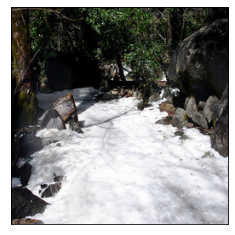

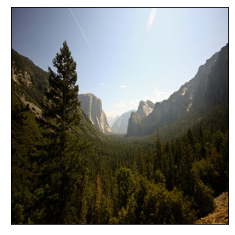

In [ ]:

winter = next(iter(winter_testdataset))
summer = next(iter(summer_testdataset))
imshow(winter.data.cpu())
imshow(summer.data.cpu())

###Создадим модель

Generator - UNet

In [ ]:
class ResidualBlock2(nn.Module):
    def __init__(self,in_dim,out_dim):
        super().__init__()
        self.conv1=nn.Sequential(nn.Conv2d(in_dim,out_dim,kernel_size=3,stride=1,padding=1),
                                 nn.InstanceNorm2d(out_dim))
        self.conv2=nn.Sequential(nn.Conv2d(out_dim,out_dim,kernel_size=3,stride=1,padding=1),
                                 nn.InstanceNorm2d(out_dim))
    def forward (self,x):
        res=F.relu(self.conv1(x))
        res=self.conv2(res)
        return res+x
class ResidualBlock5(nn.Module):
    def __init__(self,in_dim,out_dim):
        super().__init__()
        self.conv1=nn.Sequential(nn.Conv2d(in_dim,in_dim,kernel_size=3,stride=1,padding=1),
                                 nn.InstanceNorm2d(in_dim),
                                 nn.ReLU()
                                 )
        self.conv2=nn.Sequential(nn.Conv2d(in_dim,out_dim,kernel_size=3,stride=1,padding=1),
                                 nn.InstanceNorm2d(out_dim),
                                 nn.ReLU()
                                 )
        self.conv3=nn.Sequential(ResidualBlock2(out_dim, out_dim),
                                 nn.ReLU()            
                                )
        self.conv4=nn.Sequential(nn.Conv2d(out_dim,out_dim,kernel_size=3,stride=1,padding=1),
                                 nn.InstanceNorm2d(out_dim)
                                 )
    def forward (self,x):
        res=self.conv2(self.conv1(x))
        res=self.conv4(self.conv3(res))
        return res+x

#Генератор
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        #encoder
        self.enc_conv1=nn.Sequential(nn.Conv2d(in_channels=3,out_channels=32,kernel_size=7,stride=1,padding=3),
                                     nn.InstanceNorm2d(32))
        self.enc_conv2=nn.Sequential(nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2,padding=1),
                                     nn.InstanceNorm2d(64))
        self.enc_conv3=nn.Sequential(nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1),
                                     nn.InstanceNorm2d(128))
        self.enc_conv4=nn.Sequential(nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1),
                                     nn.InstanceNorm2d(128))
        self.enc_conv5=nn.Sequential(nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=2,padding=1),
                                     nn.InstanceNorm2d(256))
        #bottleneck
        self.bn=nn.Sequential(ResidualBlock2(256,256),ResidualBlock5(256,256),
                              ResidualBlock2(256,256),ResidualBlock2(256,256),
                              ResidualBlock2(256,256),ResidualBlock2(256,256),
                              ResidualBlock2(256,256),ResidualBlock5(256,256),
                              ResidualBlock2(256,256),ResidualBlock2(256,256),
                              ResidualBlock2(256,256),ResidualBlock2(256,256)
                              )
                               
        #decoder
        self.dec_conv1=nn.Sequential(nn.ConvTranspose2d(in_channels=512,out_channels=128,kernel_size=4,stride=2,padding=1),
                                     nn.InstanceNorm2d(128))
        self.dec_conv2=nn.Sequential(nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1),
                                     nn.InstanceNorm2d(128))
        self.dec_conv3=nn.Sequential(nn.ConvTranspose2d(in_channels=256,out_channels=64,kernel_size=4,stride=2,padding=1),
                                     nn.InstanceNorm2d(64))
        self.dec_conv4=nn.Sequential(nn.ConvTranspose2d(in_channels=128,out_channels=32,kernel_size=4,stride=2,padding=1),
                                     nn.InstanceNorm2d(32))
        self.dec_conv5=nn.Sequential(nn.Conv2d(in_channels=64,out_channels=3,kernel_size=3,padding=1))

    def forward(self,x):
        e1=F.relu(self.enc_conv1(x))
        e2=F.relu(self.enc_conv2(e1))
        e3=F.relu(self.enc_conv3(e2))
        e4=F.relu(self.enc_conv4(e3))
        e5=F.relu(self.enc_conv5(e4))
        bn=self.bn(e5)
        d1=F.relu(self.dec_conv1(torch.cat((e5,bn),1)))
        d2=F.relu(self.dec_conv2(torch.cat((e4,d1),1)))
        d3=F.relu(self.dec_conv3(torch.cat((e3,d2),1)))
        d4=F.relu(self.dec_conv4(torch.cat((e2,d3),1)))
       # print(d4.shape, )
        #d3=torch.tanh(self.dec_conv3(d2))
        d3=torch.tanh(self.dec_conv5(torch.cat((e1,d4),1)))
        return d3


In [ ]:
summary(UNet().to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           4,736
    InstanceNorm2d-2         [-1, 32, 256, 256]               0
            Conv2d-3         [-1, 64, 128, 128]          18,496
    InstanceNorm2d-4         [-1, 64, 128, 128]               0
            Conv2d-5          [-1, 128, 64, 64]          73,856
    InstanceNorm2d-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 128, 32, 32]         147,584
    InstanceNorm2d-8          [-1, 128, 32, 32]               0
            Conv2d-9          [-1, 256, 16, 16]         295,168
   InstanceNorm2d-10          [-1, 256, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]         590,080
   InstanceNorm2d-12          [-1, 256, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         590,080
   InstanceNorm2d-14          [-1, 256,

Discriminator

In [ ]:

class discriminator (nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Sequential(nn.Conv2d(in_channels=3,out_channels=64,kernel_size=4,stride=2,padding=1),
                                     nn.InstanceNorm2d(64))
        self.conv2=nn.Sequential(nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1),
                                     nn.InstanceNorm2d(128))
        self.conv3=nn.Sequential(nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1),
                                     nn.InstanceNorm2d(256))
        self.conv4=nn.Sequential(nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1),
                                     nn.InstanceNorm2d(512))
        self.out=nn.Sequential(nn.Conv2d(512,1,4,1))

        self.avg=nn.AdaptiveAvgPool2d(1)

    def forward(self,x):
        c1=F.leaky_relu(self.conv1(x),negative_slope=0.2, inplace=True)
        c2=F.leaky_relu(self.conv2(c1),negative_slope=0.2, inplace=True)
        c3=F.leaky_relu(self.conv3(c2),negative_slope=0.2, inplace=True)
        c4=F.leaky_relu(self.conv4(c3),negative_slope=0.2, inplace=True)
        res=self.avg(self.out(c4))
        return torch.squeeze(torch.squeeze(res, 2), 2)
         

In [ ]:
summary(discriminator().to(device), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
    InstanceNorm2d-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
            Conv2d-5          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 512, 16, 16]       2,097,664
    InstanceNorm2d-8          [-1, 512, 16, 16]               0
            Conv2d-9            [-1, 1, 13, 13]           8,193
AdaptiveAvgPool2d-10              [-1, 1, 1, 1]               0
Total params: 2,764,737
Trainable params: 2,764,737
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 30.00
Params size (MB): 10.55
Estim

Создадим модели и функции потерь

###Обучим модель

In [ ]:
d_steps = 50
g_steps = 50
batch_size = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
gs2w = UNet().to(device)
gw2s = UNet().to(device)
ds = discriminator().to(device)
dw = discriminator().to(device)
#summary(dis, (1, 28, 28, 1))
#summary(gen, (1, 28, 28, 1))
gs2wLoss = nn.MSELoss()
gs2woptim = optim.Adam(gs2w.parameters(), lr=0.0002)

dsLoss = nn.MSELoss()
dsoptim = optim.Adam(ds.parameters(), lr=0.0002)

gw2sLoss = nn.MSELoss()
gw2soptim = optim.Adam(gw2s.parameters(), lr=0.0002)

dwLoss = nn.MSELoss()
dwoptim = optim.Adam(dw.parameters(), lr=0.0002)

oopLoss = nn.MSELoss()
#oopoptim = optim.Adam(gen.parameters(), lr=0.0002)# xxxxxxxxxxxxxxxxxx.parameters()

printing_steps = 1

epochs = 3000

filepath = '/content/gdrive/My Drive/Gan and style transfer - homework/GAN/model/tran'


cuda


In [ ]:
os.getcwd()

'/content/gdrive/My Drive/Gan and style transfer - homework'

In [ ]:
state = torch.load(filepath + "1_1gs2w" + '.pt')
gs2w.load_state_dict(state['state_dict'])
gs2woptim.load_state_dict(state['optimizer'])

state = torch.load(filepath + "1_1gw2s" + '.pt')
gw2s.load_state_dict(state['state_dict'])
gw2soptim.load_state_dict(state['optimizer'])

state = torch.load(filepath + "1_1ds" + '.pt')
ds.load_state_dict(state['state_dict'])
dsoptim.load_state_dict(state['optimizer'])

state = torch.load(filepath + "1_1dw" + '.pt')
dw.load_state_dict(state['state_dict'])
dwoptim.load_state_dict(state['optimizer'])



Обучим модель

In [ ]:
for WinterImg, SummerImg in zip(data_train_winter, data_train_summer):
  if(WinterImg.shape[0] != 5) or (SummerImg.shape[0] != 5):
          continue
  print(WinterImg.shape, SummerImg.shape)

torch.Size([5, 3, 256, 256]) torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256]) torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256]) torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256]) torch.Size([5, 3, 256, 256])
torch.Size([5, 3, 256, 256]) torch.Size([5, 3, 256, 256])


KeyboardInterrupt: ignored

In [ ]:
for epoch in range(epochs):
    #apple == summer, orange == winter xd//
    print(epoch)
    img = []
    # training discriminators
    d_loss1 = 0 
    d_loss2 = 0
    gen_loss1 = 0
    gen_loss2 = 0
    gen_loss = 0
    accuracydw = 0
    accuracyds = 0
    count = 0
    for WinterImg, SummerImg in zip(data_train_winter, data_train_summer):
        if(WinterImg.shape[0] != 5) or (SummerImg.shape[0] != 5):
          continue
        count+=1
        dw.train()
        
        gs2w.train(False)
        gw2s.train(False)
        for param in dw.parameters():
          param.requires_grad = True
        

        inp_real_winter = WinterImg
        
        inp_real_winter = torch.Tensor(inp_real_winter.reshape(batch_size,3,256, 256)).to(device)
  
        inp_real_summer = SummerImg
        inp_real_summer = torch.Tensor(inp_real_summer.reshape(batch_size,3,256, 256)).to(device)


        dis_real_winter_out = dw(inp_real_winter)

        dis_real_winter_loss = dwLoss(dis_real_winter_out,
                              torch.ones(batch_size, 1).to(device))
        fake_winter_out = gs2w(inp_real_summer)
        dis_fake_winter_out = dw(fake_winter_out)
        dis_fake_winter_loss = dwLoss(dis_fake_winter_out,
                              torch.zeros(batch_size, 1).to(device))
        accuracydw += F.l1_loss(dis_real_winter_out, torch.ones(batch_size,1).to(device)) + F.l1_loss(dis_fake_winter_out, torch.zeros(batch_size,1).to(device))
        
        d_winter_loss = 0.5 * (dis_real_winter_loss + dis_fake_winter_loss)
        dw.zero_grad()

        d_winter_loss.backward()
        dwoptim.step()
        for param in dw.parameters():
          param.requires_grad = False


        ds.train()
        for param in ds.parameters():
          param.requires_grad = True
        
        
        dis_real_summer_out = ds(inp_real_summer)
        dis_real_summer_loss = dsLoss(dis_real_summer_out,
                              torch.ones(batch_size, 1).to(device))
        fake_summer_out = gw2s(inp_real_winter)
        dis_fake_summer_out = ds(fake_summer_out)
        dis_fake_summer_loss = dsLoss(dis_fake_summer_out,
                              torch.zeros(batch_size, 1).to(device))
        
        accuracyds += F.l1_loss(dis_real_summer_out, torch.ones(batch_size,1).to(device)) + F.l1_loss(dis_fake_summer_out, torch.zeros(batch_size,1).to(device))

        d_summer_loss = 0.5 * (dis_real_summer_loss + dis_fake_summer_loss)
        d_loss2 += d_winter_loss
        d_loss1 += d_summer_loss
        ds.zero_grad()
        
        d_summer_loss.backward()

        dsoptim.step()
            
        for param in ds.parameters():
          param.requires_grad = False
        
    # training generators 

        gs2w.train()
        gw2s.train()
        dw.train(False)
        ds.train(False)
        for param in gs2w.parameters():
          param.requires_grad = True
        for param in gw2s.parameters():
          param.requires_grad = True

        real_summer_img = torch.Tensor(SummerImg.reshape(batch_size,3,256, 256)).to(device)
        real_winter_img = torch.Tensor(WinterImg.reshape(batch_size,3,256, 256)).to(device)
        #generators loss
        summer_fake = gw2s(real_winter_img)
        winter_fake = gs2w(real_summer_img)


        dis_summer = ds(summer_fake)
        dis_winter = dw(winter_fake)

        summer_loss = gw2sLoss(dis_summer,
                               torch.ones(batch_size,1).to(device))
        winter_loss = gs2wLoss(dis_winter,
                               torch.ones(batch_size,1).to(device))
        gen_loss1 += summer_loss
        gen_loss2 += winter_loss
        loss_generators = summer_loss + winter_loss 
        #cycle loss
      
        winter_fake1 = gs2w(real_summer_img)
        summer_fake1 = gw2s(real_winter_img)
        cycle_summer = gw2s(winter_fake1)
        cycle_winter = gs2w(summer_fake1)

        loss_cycle_1 = F.l1_loss(cycle_winter, real_winter_img)
        loss_cycle_2 = F.l1_loss(cycle_summer, real_summer_img)

        loss_cycle = 10 * (loss_cycle_1 + loss_cycle_2)
        gen_loss += loss_cycle
        loss = loss_cycle + loss_generators
        gs2w.zero_grad()
        gw2s.zero_grad()
        loss.backward()
        gs2woptim.step()
        gw2soptim.step()
 
        for param in gs2w.parameters():
          param.requires_grad = False
        for param in gw2s.parameters():
          param.requires_grad = False


    if epoch%printing_steps==0:
        gs2w.eval()
        gw2s.eval()
        accuracydw /= count
        accuracyds /= count
        print ("%d [Ds: %f, Dw: %f| accuracy: summer: %f, winter: %f] [Gs2w: %f Gw2s: %f Gcycle %f]" % (epoch, d_loss1, d_loss2, accuracyds, accuracydw, gen_loss1, gen_loss2, gen_loss))
        savec()
        state = {
            'epoch': epoch,
            'state_dict': ds.state_dict(),
            'optimizer': dsoptim.state_dict()
        }
        torch.save(state, filepath + "1_1ds" + '.pt')

        state = {
            'epoch': epoch,
            'state_dict': dw.state_dict(),
            'optimizer': dwoptim.state_dict()
        }
        torch.save(state, filepath + "1_1dw"  + '.pt')

        state = {
            'epoch': epoch,
            'state_dict': gs2w.state_dict(),
            'optimizer': gs2woptim.state_dict()
        }
        torch.save(state, filepath + "1_1gs2w" + '.pt')

        state = {
            'epoch': epoch,
            'state_dict': gw2s.state_dict(),
            'optimizer': gw2soptim.state_dict()
        }
        torch.save(state, filepath + "1_1gw2s"  + '.pt')
        
        print("\n\n")

0
0 [Ds: 46.081688, Dw: 45.406830| accuracy: summer: 0.923404, winter: 0.910699] [Gs2w: 63.968575 Gw2s: 65.253891 Gcycle 349.721375]



1
1 [Ds: 47.046410, Dw: 44.717018| accuracy: summer: 0.931081, winter: 0.905390] [Gs2w: 64.230774 Gw2s: 65.542747 Gcycle 348.406860]



2
2 [Ds: 46.105450, Dw: 45.002174| accuracy: summer: 0.923607, winter: 0.905316] [Gs2w: 63.079510 Gw2s: 65.579269 Gcycle 342.085968]



3
3 [Ds: 46.909447, Dw: 44.061989| accuracy: summer: 0.933462, winter: 0.899862] [Gs2w: 63.078754 Gw2s: 65.139771 Gcycle 345.465851]



4
4 [Ds: 46.383701, Dw: 44.942757| accuracy: summer: 0.931788, winter: 0.908893] [Gs2w: 62.798943 Gw2s: 65.411591 Gcycle 337.260529]



5
5 [Ds: 45.696564, Dw: 44.046032| accuracy: summer: 0.927280, winter: 0.895107] [Gs2w: 62.640232 Gw2s: 65.844772 Gcycle 349.501495]



6
6 [Ds: 46.434021, Dw: 43.069664| accuracy: summer: 0.921928, winter: 0.883374] [Gs2w: 65.807327 Gw2s: 69.048126 Gcycle 340.365173]



7
7 [Ds: 45.744682, Dw: 43.694435| accuracy: sum

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).





11
11 [Ds: 44.933884, Dw: 42.984123| accuracy: summer: 0.914409, winter: 0.879624] [Gs2w: 65.068626 Gw2s: 69.423637 Gcycle 329.336548]



12
12 [Ds: 45.451859, Dw: 43.991989| accuracy: summer: 0.923555, winter: 0.894333] [Gs2w: 62.758728 Gw2s: 68.260681 Gcycle 324.157867]



13
13 [Ds: 46.536465, Dw: 42.619980| accuracy: summer: 0.919956, winter: 0.866742] [Gs2w: 66.074493 Gw2s: 72.121078 Gcycle 339.622284]



14
14 [Ds: 45.411911, Dw: 43.790855| accuracy: summer: 0.921941, winter: 0.887925] [Gs2w: 63.383034 Gw2s: 69.504997 Gcycle 324.743896]



15
15 [Ds: 44.523079, Dw: 40.932922| accuracy: summer: 0.910128, winter: 0.859640] [Gs2w: 65.222519 Gw2s: 70.795212 Gcycle 323.353699]



16
16 [Ds: 46.377243, Dw: 41.576664| accuracy: summer: 0.933809, winter: 0.854245] [Gs2w: 62.101803 Gw2s: 73.584877 Gcycle 325.299377]



17
17 [Ds: 45.536652, Dw: 42.443306| accuracy: summer: 0.915877, winter: 0.860306] [Gs2w: 64.405197 Gw2s: 73.050072 Gcycle 318.250946]



18
18 [Ds: 43.803944, Dw: 41.96

Выше вначале идет картинка летняя, потом переведенная в зиму версия. 
Есть баг, что часто переводит в осень, а не зиму. Вероятно из-за недообучения.

In [ ]:
os.getcwd()
os.chdir('/content/gdrive/My Drive/Gan and style transfer - homework/GAN/')

In [ ]:
os.getcwd()
#os.mkdir('images')
os.getcwd()

'/content/gdrive/My Drive/Gan and style transfer - homework/GAN'

In [ ]:
def savec():
  import cv2
  x = next(iter(data_test_summer))
  gw2s.eval()
  gs2w.eval()
  y = (gs2w(torch.Tensor(x).to(device)))
  #summer to winter
  x = x[0].numpy()
  x = (np.transpose(x, (1, 2, 0)) + 1)/2
  y = y.detach().cpu().numpy()
  y = y[0]
  y = (np.transpose(y, (1, 2, 0)) + 1)/2
  im_v = cv2.vconcat([x, y]).transpose((2, 0, 1))
  
  im_v = im_v.transpose((1, 2, 0))
  fig, axs = plt.subplots(1, 1)
  axs.imshow(im_v,cmap='binary')
  fig.show()
  fig.savefig("images/1_1s2w.jpg")

  #winter to summer
  x = next(iter(data_test_winter))
  y = (gw2s(torch.Tensor(x).to(device)) )
  x = x[0].numpy()
  y = y[0]
  x = (np.transpose(x, (1, 2, 0)) + 1)/2
  y = y.detach().cpu().numpy()
  y = (np.transpose(y, (1, 2, 0)) + 1)/2
  im_v = cv2.vconcat([x, y]).transpose((2, 0, 1))
  
  im_v = im_v.transpose((1, 2, 0))
  fig, axs = plt.subplots(1, 1)
  axs.imshow(im_v,cmap='binary')
  fig.show()
  fig.savefig("images/1_1w2s.jpg")  



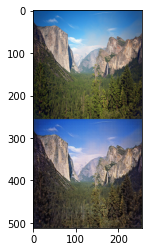

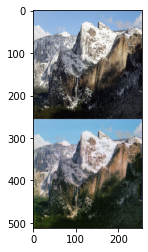

In [ ]:
savec()